In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Define a second degree function for a simple starting:

> Add blockquote



In [ ]:
def f(x):
  return x**2 -6*x +5 #(x-5)*(x-1)


Then:

In [ ]:
f(5.0)

0.0

In [ ]:
f(6.0)

5.0

Plot the curve of the f(x):

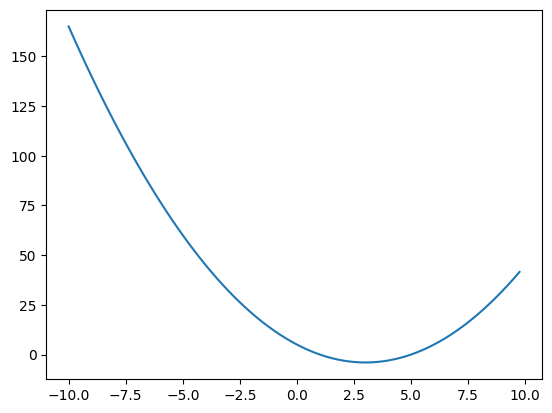

In [ ]:
xs = np.arange(-10,10,0.25)
ys = f(xs)
plt.plot(xs,ys)

Then then calculate the instant differentiation in a point (derivative):

In [ ]:
h = 0.0000001
x1 = 5
x2 = 7.5

dx1= (f(x1+h)-f(x1))/h
dx2= (f(x2+h)-f(x2))/h

print(f"dx1/x1: {dx1}, dx2/x2: {dx2}")



dx1/x1: 4.000000117798663, dx2/x2: 9.00000017622915


Calculate the slope in terms of a,b,c respectively. Nothing changed:

In [ ]:
h = 0.0000001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
d2 = a*b + c

print('d1: ', d1)
print('d2: ',d2)
print('slope: ',(d2-d1)/h)


d1:  4.0
d2:  4.0
slope:  0.0


a changes:

In [ ]:
h = 0.0000001

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c # 2.0*-3.0 + 10.0
a += h
d2 = a*b + c

print('d1: ', d1)
print('d2: ',d2)
print('slope (a changed): ',(d2-d1)/h)

d1:  4.0
d2:  3.9999997
slope (a changed):  -2.9999999995311555


b changed:

In [ ]:
h = 0.0000001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c # 2.0*-3.0 + 10.0
b += h
d2 = a*b + c

print('d1: ', d1)
print('d2: ',d2)
print('slope (b changed): ',(d2-d1)/h)

d1:  4.0
d2:  4.0000002
slope (b changed):  1.9999999967268423


When a node is **used more than once** (e.g. `b = a + a`), gradients can be **overwritten** instead of **added**.

**Wrong behavior:**

```python
self.grad = 1.0 * out.grad
other.grad = 1.0 * out.grad
```

Both `self` and `other` point to the same object (`a`), so the second line **overwrites** the first one.
Result: `a.grad = 1` (should be `2`)

**Fix:**

```python
self.grad += 1.0 * out.grad
other.grad += 1.0 * out.grad
```

Using `+=` **accumulates** gradients when a variable contributes multiple times.
Now `a.grad = 2`

## Overriding some “dunder” (double underscore) methods or magic methods (add, mul, etc.)

In [ ]:
class Value:
  #children: array, op(operator): char
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data+other.data ,(self,other), "+")

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out
  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data*other.data ,(self,other), "*")

    def _backward():
      self.grad += 1.0 * out.grad * other.data
      other.grad += 1.0 * out.grad * self.data
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad #power rule and chaining rule
    out._backward = _backward

    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

    return out

  #tanh = e power of 2x + 1 / e power of 2x -1
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    # our self => t , children => previous self
    out = Value(t, (self, ), 'tanh')

    def _backward():
      local_grad = (1 - t**2)
      # out grad is equal to tanh derivatived self grad
      self.grad = local_grad * out.grad

    out._backward = _backward
    return out

#  Implement the topo-sort for process all of the nodes in our neuron for doing backward with one single call
  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()





Graph function for visualizing nodes:

In [ ]:
from graphviz import Digraph
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label,n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot
#a = 2, b = -3 , c = 10 , d = e + c ,e = a*b ,f=-2 ,L=d*f
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d  = e + c; d.label = 'd'
f = Value(-2.0, label= 'f')
L = d*f;L.label = 'L'
L

Value(data=-8.0)

In [ ]:
L.grad = 1.0;

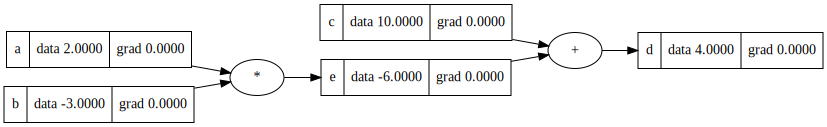

In [ ]:
draw_dot(d)

In [ ]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

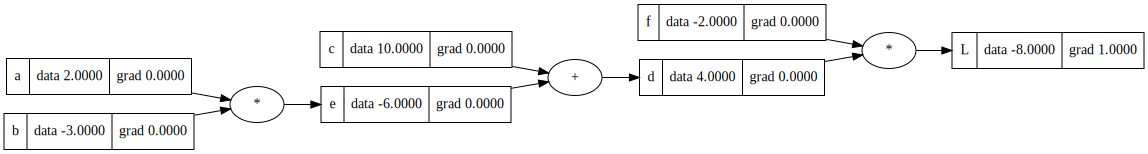

In [ ]:
draw_dot(L)

Lets do some operations with weights and biases:

In [ ]:
#inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

#bias of the neuron
b = Value(6.8813735870195432, label='b')

#x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = "x1*w1"
x2w2 = x2*w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b; n.label = "n"
o = n.tanh(); o.label = "o"


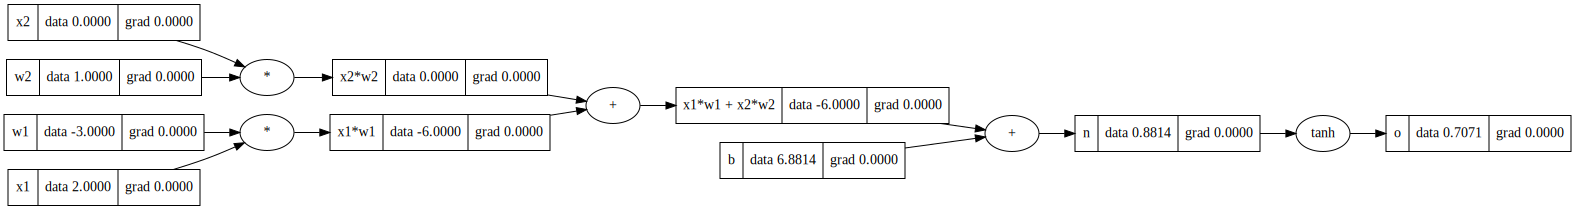

In [ ]:
draw_dot(o)

Define the grads:

In [ ]:
o.grad = 1.0

In [ ]:
o._backward()

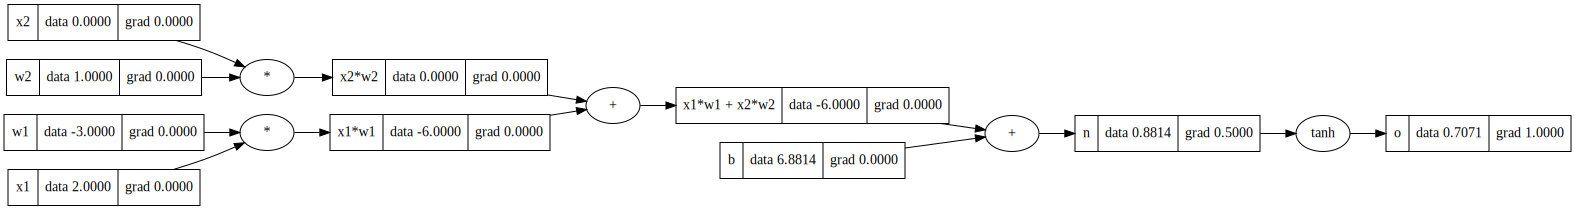

In [ ]:
draw_dot(o)

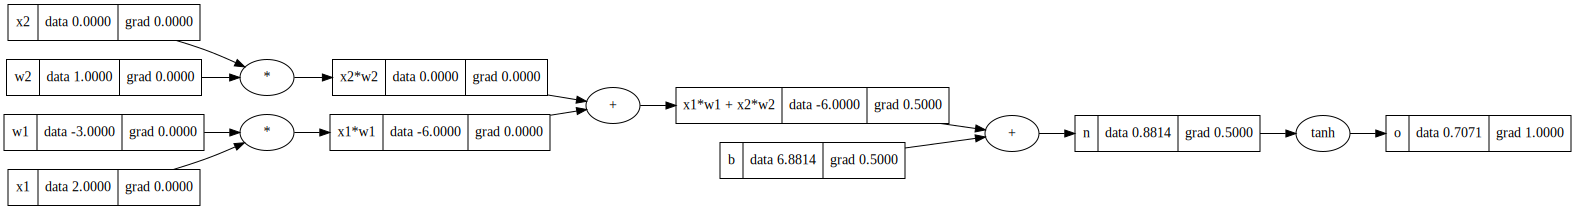

In [ ]:
 n._backward()
 draw_dot(o)

B is a leaf node, its not have backward.

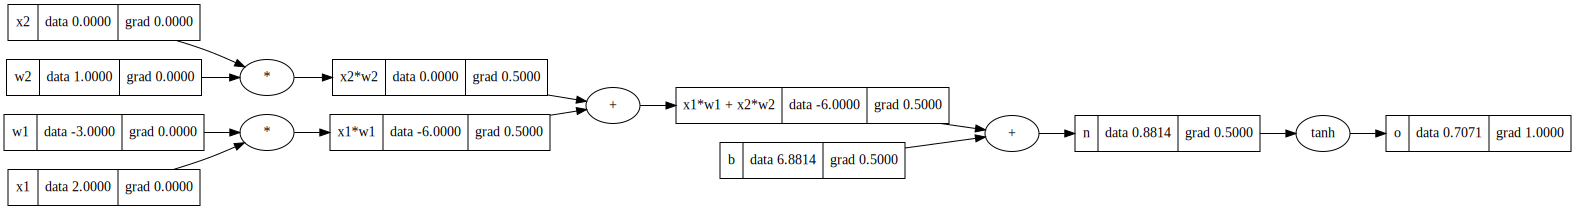

In [ ]:
x1w1x2w2._backward()
draw_dot(o)

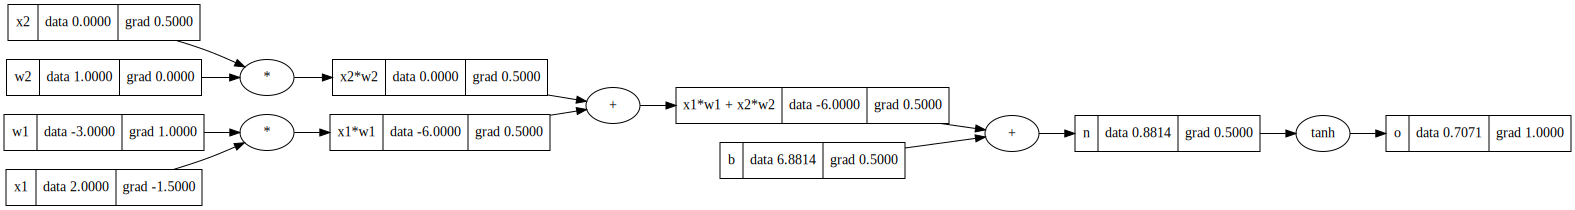

In [ ]:
x2w2._backward()
x1w1._backward()
draw_dot(o)

In [ ]:
o.backward()

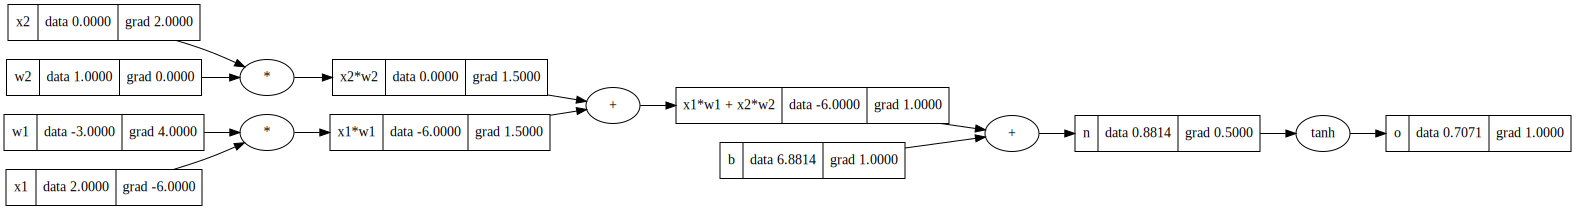

In [ ]:
draw_dot(o)

When a node is **used more than once**:

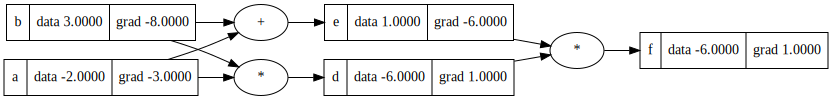

In [ ]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

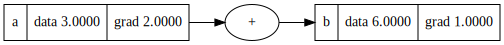

In [ ]:
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

# SECOND PART:

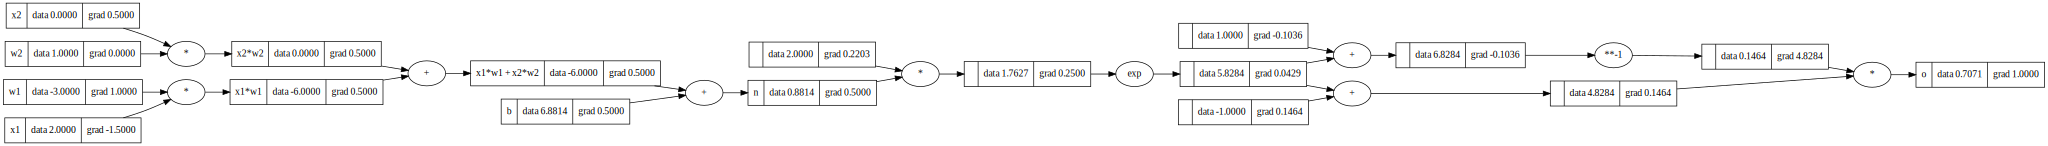

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [ ]:
import torch

In [ ]:
x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True
w1 = torch.Tensor([-2.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('------')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.99373475240515
------
x2 0.01249124186227529
w2 0.0
x1 -0.02498248372455058
w1 0.02498248372455058


In [ ]:
import random

class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [ ]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.1691589517498993)

In [ ]:
#data
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

## Training (Best Part):

In [ ]:
#forward pass
for k in range(20):
  ypred = [n(x) for x in xs]
  loss = sum(((yout - Value(ygt))**2 for ygt, yout in zip(ys, ypred)), start=Value(0.0))

  #backward pass

  #zero grad in pytorch
  for p in n.parameters():
    p.grad = 0.0

  loss.backward()

  #update (gradient descent)
  for p in n.parameters():
    p.data += -0.05 * p.grad # Changed from + to * and added learning rate 0.1

  print(k, loss.data)

0 0.005700836457574173
1 0.00565501153166826
2 0.005609887972960667
3 0.005565450073089967
4 0.0055216825848302155
5 0.005478570705398042
6 0.005436100060476495
7 0.00539425668891996
8 0.005353027028106947
9 0.005312397899908738
10 0.005272356497244128
11 0.005232890371192034
12 0.0051939874186350925
13 0.00515563587040927
14 0.005117824279935082
15 0.005080541512308303
16 0.005043776733828446
17 0.005007519401944709
18 0.004971759255600369
19 0.004936486305957064


The output of the last cell shows the predicted values (ypred) after 20 iterations of training. You can see that these values are getting closer to the desired target values (ys) defined earlier. This indicates that the model is learning to predict the correct outputs.



In [ ]:
ypred

[Value(data=0.9653362160989961),
 Value(data=-0.9821031118351217),
 Value(data=-0.9538324905055731),
 Value(data=0.9641786257561578)]